


<p>
<img src="./pics/header.svg" style="float: center"/>
</p>

***

# B2 - from MCK to FRFs
> - #### Miha Kodrič $\,\,$ *miha.kodric@fs.uni-lj.si*
> - #### Gregor Čepon $\,\,$ *gregor.cepon@fs.uni-lj.si*

***

> ### <i class="fa fa-graduation-cap" aria-hidden="true"></i> Lesson highlights  
> - #### importing mass and stiffness matrices to pyFBS
> - #### performing modal analysis of numerical model
> - #### 3D visualization of modeshpes
> - #### generation of FRFs at specific locations

***

# Numerical models

### Importance of numerical modelling
 - The development of a new product usually begins with numerical situations.
 - Numerical models are suitable for performing optimizations
 - All new methodologies are first tested on numerical data.
 
#### Pros:
 - no experimental errors
 - defined at arbitrary locations or directions
 - digital twin of real system
 - useful in the development phase (no need for prototypes)
 
#### Cons:
 - many assumptions and simplifications in material geometry and boundary conditions
 - long calculation times
 - very challenging modelling procedure for complex systems

# 1. Creating ``pyFBS.MK_model`` class

``pyFBS.MK_model`` is a class that contains a numerical model of the analysed structure in form of mass and stiffness matrices. Currently, there are supported two ways of creating that class:
 1. Manual definition of mass and stiffness matrices and node locations with elements definition.
 2. Direct import of mass and stiffness matrix and finite element model from commercial software (currently only Ansys is supported).

After the ``pyFBS.MK_model`` class initialization, there are many methods, that can be used on this object (computation of eigenfrequencies, eigenvectors, FRF generation). Outputs of these methods can be combined with interactive 3D display, or other methods included in the ``pyFBS`` package.

# 2. Creating ``pyFBS.MK_model`` class manually
Mass and stiffness matrices can be provided by any finite element method code, you can code it yourself, or you can use any of the libraries that already exist. 

In [1]:
import numpy as np
import pandas as pd
import pyvista as pv
import matplotlib.pyplot as plt

import pyFBS

In [2]:
pyFBS.download_lab_testbench()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 8013.96it/s]

For this case, let us assume, that the analysed system is a simple 4-DoFs system.
<p>
<img src="./pics/basic_4_DoF_example.svg?2" width=300/>
</p>

For such a simple system it is easy to derive the mass and stiffness matrices. Mass and stiffness matrices can be provided by any other program, it is only necessary that they have a form of ``numpy`` array.

In [3]:
m1, m2, m3, m4 = 1., 1., 1., 1.
k1, k2, k3 = 200., 200., 200.

mass_matrix = np.array([
    [m1, 0, 0, 0],
    [0, m2, 0, 0],
    [0, 0, m3, 0],
    [0, 0, 0, m4]])
stifenss_matrix = np.array([
    [k1, -k1, 0, 0],
    [-k1, k1+k2, -k2, 0],
    [0, -k2, k2+k3, -k3],
    [0, 0, -k3, k3]])

## 2.1. Geometry preparation

For visualization purposes, it is necessary to define node locations and connectivity between them to ensure a nicer render of deformed structure when animating mode shape.

Our case is combined from point masses, therefore the appropriate visualization is to use simple spheres to show DoFs.

Every node must be defined with 3 coordinates in space.

In [4]:
x = np.arange(4)
y = np.zeros(4)
z = np.zeros(4)
points = np.array([x, y, z]).T

To be able to use this MK_model class in other applications inside ``pyFBS`` it is necessary to connect system matrices (mass and stiffness) with points and directions. Here is defined which DoF presents specific location in system matrices: first column in ``dof_ref`` array represents the index of point, starting with index 1, second column in ``dof_ref`` array represents the direction of that DoF - 0-x, 1-y, 2-z. Line order in ``dof_ref`` must be the same as is in system matrices.

In [5]:
dof_ref = np.array([
    [1, 0],
    [2, 0],
    [3, 0],
    [4, 0],
])

<div class="alert alert-block alert-warning">
    <i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
    <b>Warning!</b> 
    <br>
    First column in <code>dof_ref</code> refers to index of DoF in mass or stiffness matrix and <b>start numbering with index 1</b> .
    <br>
    Second column in <code>dof_ref</code> refers to directions of DoF in mass or stiffness matrix and is defined by <b>0-x, 1-y, 2-z</b> .
</div>

Using ``pyvista`` class ``PolyData`` is defined geometry and will be later used for visualization of mode shape.

In [6]:
grid = pv.PolyData(points)

It is possible to define also line connection between points. In every line of the array, we define the connection between indexes of two points - starting with index 0.

In [7]:
cells = np.array([
    [0, 1],
    [1, 2],
    [2, 3]
])
grid_with_lines = pv.PolyData(points, lines = cells)

## 2.2. ``MK_model`` initialization

Now, when everything is prepared, we can finally initialize ``MK_model`` class.

In [8]:
MK_manual = pyFBS.MK_model(
    manual_mass_matrix=mass_matrix,
    manual_stifenss_matrix=stifenss_matrix,
    no_modes=100,
    allow_pickle=True,
    recalculate=True)

MK_manual.manual_mesh_definition(grid, dof_ref) # must be added separately since we created our geometry/mesh

C:\Users\kodric\Anaconda3\lib\site-packages\scipy\sparse\linalg\eigen\arpack\arpack.py:1593: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


This object ``MK_manual`` now contains crucial dynamic properties about the analysed system, like eigenfrequencies, eigenvectors.
<p>
<img src="./pics/full_modal_matrix4x4.svg" width=300/>
</p>

In [9]:
MK_manual.eig_freq # eigenfrequencies in rad/s
MK_manual.eig_vec # mass-normalized eigenvectors in form of a modal matrix: columns - eigenfrequencies, rows-DoFs

array([[-0.5       ,  0.65328148,  0.5       , -0.27059805],
       [-0.5       ,  0.27059805, -0.5       ,  0.65328148],
       [-0.5       , -0.27059805, -0.5       , -0.65328148],
       [-0.5       , -0.65328148,  0.5       ,  0.27059805]])

## 2.3. Mode shape visualization
Mode shape visualization is performed inside interactive 3D viewer included in ``pyFBS`` package. Visualization starts with opening a pop-up window:

In [10]:
manual_model_viewer = pyFBS.view3D(show_origin=False, show_axes=False)

The geometry of the analysed model is imported to the 3D viewer through ``pyvista`` method as shown below. This method ``add_mesh`` has numerous parameters which are described [here](https://docs.pyvista.org/plotting/plotting.html#pyvista.BasePlotter.add_mesh). 

In [11]:
# only for showing the undeformed shape
manual_model_viewer.plot.add_mesh(grid.copy(), scalars = np.ones(grid.points.shape[0]), 
                                  cmap = "coolwarm", show_edges=True, 
                                  render_lines_as_tubes=True, line_width=10,
                                  render_points_as_spheres = True, point_size=50.0, opacity = 0.1
                                 )

manual_model_viewer.plot.add_mesh(grid, scalars = np.ones(grid.points.shape[0]), 
                                  cmap = "coolwarm", show_edges=True, 
                                  render_lines_as_tubes=True, line_width=10,
                                  render_points_as_spheres = True, point_size=50.0
                                 )

(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)000001B8176910A0

To visualize the mode shape upon defined geometry, it is necessary to define a 3D displacement vector for a specific mode shape. 

In [12]:
mode_shape = MK_manual.get_modeshape(0) # build-in pyFBS function to get the desired mode shape

mode_dict = pyFBS.dict_animation(mode_shape, "modeshape",pts=points, mesh=grid, r_scale=0.1)

# to save gif animation
# manual_model_viewer.take_gif = True
# manual_model_viewer.gif_dir = "modeshape.gif"

manual_model_viewer.add_modeshape(mode_dict,run_animation = True,add_note = False)

In [13]:
manual_model_viewer.plot.camera_position

[(4.846065214951231, 3.3460652149512318, 3.3460652149512318),
 (1.5, 0.0, 0.0),
 (0.0, 0.0, 1.0)]

In [14]:
manual_model_viewer.plot.camera_position = [(1.4499290342037081, 0.0, -5.98901431377391),
 (1.4499290342037081, 0.0, 0.0),
 (0.0, 1.0, 0.0)]

## 2.3. Generation of FRF matrix

### 2.3.1. Full harmonic method
FRFs for the small systems can be efficiently computed using Full space method:
$$\mathbf{M} \, \boldsymbol{\ddot{x}}(t) + \mathbf{K} \, \boldsymbol{x}(t) = \boldsymbol{f}(t).$$

for transformation to frequency domain is used:
$$\boldsymbol{x}(t)=\boldsymbol{X}\,e^{\text{i}\,\omega\,t},\ \
\boldsymbol{\ddot{x}}(t)=-\omega^2\boldsymbol{X}\,e^{\text{i}\,\omega\,t},\ \
\boldsymbol{f}(t)=\boldsymbol{F}\,e^{\text{i}\,\omega\,t}$$

and we get:
$$\left(-\mathbf{M} \, \omega^2+ \mathbf{K}\right) \, \boldsymbol{X}\,e^{\text{i}\,\omega\,t} = \boldsymbol{F}\,e^{\text{i}\,\omega\,t},$$
$$\left(-\mathbf{M} \, \omega^2+ \mathbf{K}\right) \, \boldsymbol{X} = \boldsymbol{F}.$$

So, the FRF matrix is defined as:
$$\boldsymbol{H}(\omega) =\frac{\boldsymbol{X}(\omega)}{\boldsymbol{F}(\omega)} = (\mathbf{K}-\omega^2\,\mathbf{M})^{-1}.$$

Using this formulation, FRFs are generated at all DoFs included in the mass and stiffness matrix. This can cause problems in the case of bigger models with a higher number of DoFs. Hence, computations can be very time and memory consuming.

<div class="alert alert-block alert-warning">
    <i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
    <b>Warning!</b> 
    Currently is possible to generate FRF using the full harmonic method only for undamped systems. You can add damping by including Rayleigh damping coefficients and change input mass and stiffness matrices.
</div>

In [15]:
MK_manual.FRF_synth_full(f_start=0, f_end=5,f_resolution=0.01)
FRF_full = MK_manual.FRF

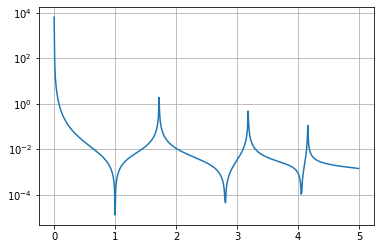

In [16]:
fig, ax = plt.subplots(1, 1)
ax.semilogy(MK_manual.freq, np.abs(np.abs(MK_manual.FRF[:, 0, 0])))
plt.grid()

<div class="alert alert-block alert-info">
    <i class="far fa-keyboard" aria-hidden="true"></i>
    The full harmonic method is more appropriate for smaller systems since the output of this function is the admittance matrix, defined at all locations of the numerical model. In the case of a large system, this could result in a huge matrix and long computational times. 
</div>

### 2.3.2 Modal superposition method
There is also another way to more efficiently generate FRF using Modal Superposition Method. 

Modal superposition method uses mass normalized mode shapes to generate FRF, where contributions of modes are superposed at each frequency point using the equation: 

$$\alpha_{i, j} = \sum_{r=1}^{m}\frac{\boldsymbol{\phi}_{i,r}\,\boldsymbol{\phi}_{j,r}}{-\omega^2+2\,i\,\omega\,\xi_r\,\omega_r+\omega_r^2}\,.$$

This method is super time efficient but can inovle modal truncation. Here is not necessary to generate FRFs at all locations represented in mass and stiffness matrices, but can be manually defined, at which locations and directions, are gonna be generated FRFs. 

In [17]:
# FRFs at all DoFs
df_response_all = pd.DataFrame({
    "Position_1": points[:, 0],
    "Position_2": points[:, 1],
    "Position_3": points[:, 2],
    "Direction_1": np.ones(len(points)),
    "Direction_2": np.zeros(len(points)),
    "Direction_3": np.zeros(len(points)),
})
df_impact_all = pd.DataFrame({
    "Position_1": points[:, 0],
    "Position_2": points[:, 1],
    "Position_3": points[:, 2],
    "Direction_1": np.ones(len(points)),
    "Direction_2": np.zeros(len(points)),
    "Direction_3": np.zeros(len(points)),
})


# FRF only at first DoF
df_response = pd.DataFrame({
    "Position_1": points[0, 0],
    "Position_2": points[0, 1],
    "Position_3": points[0, 2],
    "Direction_1": np.ones(1),
    "Direction_2": np.zeros(1),
    "Direction_3": np.zeros(1),
})
df_impact = pd.DataFrame({
    "Position_1": points[0, 0],
    "Position_2": points[0, 1],
    "Position_3": points[0, 2],
    "Direction_1": np.ones(1),
    "Direction_2": np.zeros(1),
    "Direction_3": np.zeros(1),
})

In [18]:
MK_manual.FRF_synth(df_response_all, df_impact_all, 
                    f_start=0, f_end=5, f_resolution=0.01, 
                    limit_modes=3, n_dim = 1)
FRF_modal = MK_manual.FRF

<div class="alert alert-block alert-info">
    <i class="far fa-keyboard" aria-hidden="true"></i>
    Inside <code>FRF_synth</code> method fast computation of FRF is achieved using the Einstein summation convention by numpy method <code>np.einsum</code> - <a href="https://numpy.org/doc/stable/reference/generated/numpy.einsum.html">dcumentation</a>
    <br>
    This function is extremely useful for tensors of any dimensions, any multiplications, everything can be done very computationally efficiently and quickly.
    <a href="https://ajcr.net/Basic-guide-to-einsum/">Here</a> is a nice explanation of how to use this magic function.
</div>

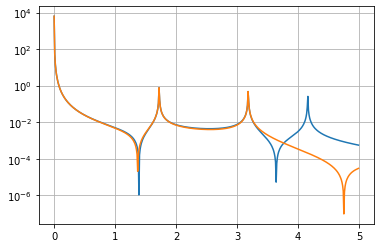

In [19]:
fig, ax = plt.subplots(1, 1)
ax.semilogy(MK_manual.freq, np.abs(np.abs(FRF_full[:, 0, 1])))
ax.semilogy(MK_manual.freq, np.abs(np.abs(FRF_modal[:, 0, 1])))
plt.grid()

### 2.3.3. Modal superposition using custom modal matrices - no need to define ``MK_model`` class
Here are eigenvectors of response and impact locations defined manually. In the presented are condensed responses only at first and third DoF while the impact is defined only at the first two DoFs. There is no modal truncation since all modes are taken into account by eigenvectors and eigenfrequencies. 

In [20]:
eig_vec_responses = MK_manual.eig_vec[[0, 2, 3],:]
eig_vec_impacts = MK_manual.eig_vec[[0, 1],:]
eig_freq_for_FRF = MK_manual.eig_freq[:]

<p>
<img src="./pics/custum_modal_matrix_FRF3x2.svg?1" width=800/>
</p>

To generate a FRF matrix directly from mode shapes, a function ``pyFBS.MK_model.custom_FRF_synth`` must be used. This function returns the frequency vector and FRF matrix in standard form. 

In [21]:
freq_coustum, frf_costum = pyFBS.MK_model.custom_FRF_synth(eig_freq_for_FRF, 
                                                           eig_vec_responses, 
                                                           eig_vec_impacts, 
                                                           f_start=0, f_end=5, f_resolution=0.01)

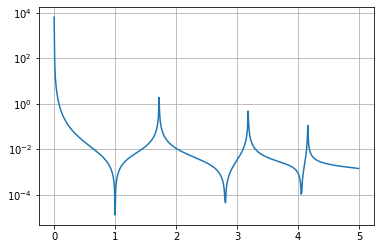

In [22]:
fig, ax = plt.subplots(1, 1)
ax.semilogy(freq_coustum, np.abs(np.abs(frf_costum[:, 0, 0])))
plt.grid()

# 3. Creating ``pyFBS.MK_model`` class from Ansys files
Modal analysis can be done already inside Anys, but by importing system matrices and finite element mesh to Python, it is possible to perform some additional steps in a pros process analysis. Just like in Ansys, pyFBS enables easy animation of mode shapes, but also highly efficient FRF generation at arbitrary impact and response directions and locations. 

To read Ansys files, the [``pyAnsys``](https://docs.pyansys.com/) library is used within pyFBS, which allows you to read both input and the result files generated by Ansys. It is also very useful as a standalone library as it allows you to import all the results from Ansys into Python and here continue the analysis with your own code.

### 1.2.1 How to set up Ansys Workbench to have access to mass and stiffness matrices

Ansys tries to be memory efficient and therefore by default deletes unneeded files. After the computation process, Ansys saves only results, while big input files for modal analysis, containing information of finite element method, are deleted. We have to disable this action, so these files are kept and available for further analysis in the pyFBS library.

Inside modal analysis system preform following steps:
 1. Go to **Modal**.
 2. Choose **Analysis Settings**.
 3. Navigate to **Analysis Data Management**.
 4. Find **Delete Unneeded files** and choose option **No**.

<img src="./pics/Animation-delete unneeded files.gif" style="width: 800px;"/>

Next, it is necessary also to change the Ansys option of distribution of solution to multiple files. If we want to use these Ansys files inside Python, we have to import a single solution file. Reading of Ansys files inside ``pyFBS`` is based on the library ``pyAnsys`` and currently, this library can not read solution files distributed to multiple parts. Therefore we have to change this default feature, to keep a single result file.

Inside modal analysis system perform following steps:
 1. Go to **File**.
 2. Choose **Solve Process Settings**.
 3. Click **Advanced**.
 4. **Uncheck** box in front of **Distribute Solution (if possible)**.

<img src="./pics/Animation-distribute solution.gif" style="width: 800px;"/>

## 3.2. ``MK_model`` initialization

In [23]:
rst_file_path = r"./lab_testbench/FEM/B.rst"
full_file_path = r"./lab_testbench/FEM/B.full"

<div class="alert alert-block alert-info">
    <i class="fa fa-info-circle" aria-hidden="true"></i>
    You can use the <code>%%time</code> command to measure cell execution time.
</div>

In [24]:
# %%time
MK_ansys = pyFBS.MK_model(rst_file=rst_file_path, 
                    full_file=full_file_path, 
                    no_modes = 100, 
                    allow_pickle = True, 
                    recalculate = False)

[100]
[160]
[3]


<div class="alert alert-block alert-success">
    <i class="fa fa-thumbs-up" aria-hidden="true"></i>
When importing a model from Ansys, the <code>MK_model</code> has many options for reading data and recalculating eigenvalues. The best way to speed up data import is to set the parameter <code>read_rst == True</code>, then the eigenvalues will not be recalculated, but the eigenvalues and eigenvectors will be read directly from the <code>rst</code> file and will restrict such values as calculated in Ansys. If <code>read_rst == False</code>, then eigen problem will be solved again in python, so defining the <code>MK_model</code> will take a bit longer. 
</div>

<div class="alert alert-block alert-warning">
    <i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
    <b>Warning!</b> 
    The imported model will only contain as many eigenvalues and eigenforms as you calculated in Ansys. If you want it to contain more, you need to re-solve the python eigen problem (by setting: <code>allow_pickle = True, read_rst == False</code>) or increase the number of calculated modal parameters directly in Ansys.
</div>

### 1.2.3 Mode shape visualization
Mode shape visualization is performed inside interactive 3D viewer included in ``pyFBS`` package. Visualization starts with opening a pop-up window:

In [39]:
automatic_model_viewer = pyFBS.view3D(show_origin=True, show_axes=False)

By adding ``.stl`` to the 3D viewer, few new features enable, like interactive positioning of impacts and responses, this ``.stl`` model will also represent the undeformed model in mode shapes animation.

In [26]:
stl = r"./lab_testbench/STL/B.stl"
automatic_model_viewer.add_stl(stl,name = "Test structure B",color = "#8FB1CC",opacity = .1)

PolyData (0x1b816189880)
  N Cells:	1230
  N Points:	597
  X Bounds:	1.072e+01, 3.504e+02
  Y Bounds:	2.050e+02, 4.114e+02
  Z Bounds:	-1.300e+01, 2.700e+01
  N Arrays:	0

Since the ``.stl`` model does not contain a mesh of finite elements it can not be animated. Therefore, we need to add finite element model mesh to the 3D view, just like we did manually in the case above. Now the mesh is already defined from Ansys and is stored in the ``MK_mode`` object at parameter ``MK_ansys.mesh``. 

In [40]:
automatic_model_viewer.plot.add_mesh(MK_ansys.mesh, 
                                     scalars = np.zeros(MK_ansys.mesh.points.shape[0]), 
                                     cmap = "coolwarm", # coolwarm, Reds
                                     clim=[-1, 1],
                                     show_edges = True,
                                     lighting=False)

(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)000001B822DF4BE0

Now we select the desired mode shape to animate using the ``get_modeshape`` method. 

In [41]:
select_mode = 8
mode_shape = MK_ansys.get_modeshape(select_mode)

mode_dict = pyFBS.dict_animation(mode_shape,"modeshape",
                                 pts = MK_ansys.pts, 
                                 mesh = MK_ansys.mesh, 
                                 fps=30, r_scale=10, 
                                 no_points=60)
automatic_model_viewer.add_modeshape(mode_dict,run_animation = True)

In [44]:
automatic_model_viewer.clear_modeshape()

## 3.3 Generation of FRF matrix
FRFs can be defined at locations where nodes of the finite element model exist. Even if you choose to generate FRF at the location where the node does not exist, pyFBS will automatically find the nearest location and generate FRF there. If the mesh is dense then the error will be really small. 

In [45]:
# FRFs at all DoFs
df_response_one = pd.DataFrame({
    "Position_1": np.array([155]),
    "Position_2": np.array([330]),
    "Position_3": np.array([-4]),
    "Direction_1": np.array([1]),
    "Direction_2": np.array([0]),
    "Direction_3": np.array([0]),
})
df_impact_one = pd.DataFrame({
    "Position_1": np.array([130]),
    "Position_2": np.array([330]),
    "Position_3": np.array([-4]),
    "Direction_1": np.array([1]),
    "Direction_2": np.array([0]),
    "Direction_3": np.array([0]),
})

In [46]:
automatic_model_viewer.show_imp(df_impact_one, color = "Green", size = 30)

In [47]:
df_impact_one_updated = MK_ansys.update_locations_df(df_impact_one)
automatic_model_viewer.show_imp(df_impact_one_updated, color = "y", overwrite = False, size = 30)

It is also possible to read predefined locations of input and output locations and put them in a form of pandas DataFrame.

In [48]:
# Path to .xslx file
xlsx = r"./lab_testbench/Measurements/AM_measurements.xlsx"

# Import and show locations of accelereometers
df_acc = pd.read_excel(xlsx, sheet_name='Sensors_B')
automatic_model_viewer.show_acc(df_acc, overwrite = True)

# Import and show directions of accelereometers channels
df_chn = pd.read_excel(xlsx, sheet_name='Channels_B')
automatic_model_viewer.show_chn(df_chn, overwrite = True)

# Import and show locations and directions of impacts
df_imp = pd.read_excel(xlsx, sheet_name='Impacts_B')
automatic_model_viewer.show_imp(df_imp, overwrite = True)

Now, we can update locations in DataFrames, to match the nearest nodes in the defined mesh. Directions of defined impact and responses will not be changed.

In [49]:
df_chn_update = MK_ansys.update_locations_df(df_chn)
df_imp_update = MK_ansys.update_locations_df(df_imp)

In [50]:
automatic_model_viewer.show_chn(df_chn_update, overwrite = False, color = "g")
automatic_model_viewer.show_imp(df_imp_update, overwrite = False, color = "g")

The result of the FRF generation would be the same if the function would be used with old (not updated) locations, because, pyFBS will do this process of finding the nearest location automatically.

In [35]:
MK_ansys.FRF_synth(df_chn_update, df_imp_update,
                   f_start=1, f_end=2000, f_resolution=1,
                   limit_modes=50, 
                   n_dim = 3,
                   modal_damping=10**-2, # classic viscous modal damping ratio
                   frf_type='receptance',)

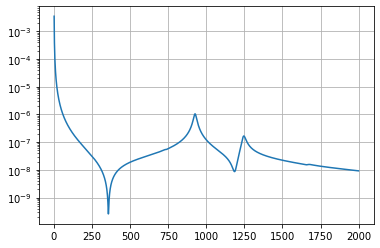

In [36]:
fig, ax = plt.subplots(1, 1)
ax.semilogy(MK_ansys.freq, np.abs(np.abs(MK_ansys.FRF[:, 0, 0])))
plt.grid()

You can add noise to the numerical measurement, to simulate experimental measurements. On `MK_model` instance you can use method `add_noise` and to acces the generated FRF you call property `FRF_noise`.

In [37]:
MK_ansys.add_noise(n1=2e-9, n2=2e-9, n3=2e-9, n4=5e-9)

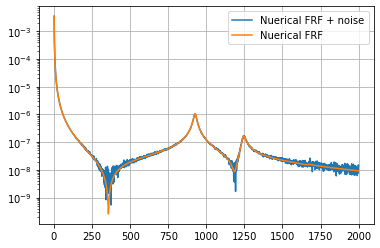

In [38]:
fig, ax = plt.subplots(1, 1)
ax.semilogy(MK_ansys.freq, np.abs(np.abs(MK_ansys.FRF_noise[:, 0, 0])), label = "Nuerical FRF + noise")
ax.semilogy(MK_ansys.freq, np.abs(np.abs(MK_ansys.FRF[:, 0, 0])), label = "Nuerical FRF")
plt.grid()
plt.legend()

> <i class="fa fa-quote-right"></i> <b>That's a wrap! Want to know more?</b> 
> <ul>
    <li> pyAnsys documentation: <a href="https://docs.pyansys.com/">https://docs.pyansys.com/</a></li>
    <li> PyVista documentation: <a href="https://docs.pyvista.org/">https://docs.pyvista.org/</a> </li>
</ul>